In [1]:
import numpy as np
import astropy.io.fits as fitsio
import matplotlib.pyplot as plt 
from astropy.table import Table, vstack
import desimodel.io
import os

import os, sys, subprocess
from collections import Counter

import numpy as np
from astropy.table import Table
from astropy.io import fits

import desimodel.io
import desimodel.focalplane
import desimodel.footprint
from desitarget.targetmask import desi_mask, obsconditions
import matplotlib.pyplot as plt
import glob

%matplotlib inline

# Functions to generate fiberassign inputs

In [2]:
def random_patch(n_dens=2500, plate_radius=1.61):
    """Generates a random set of points within a single plate.
    n_dens: number density of the random points to be generated
    plate_radius: radius of DESI plate in degrees.
    """
    n_total = int(4.0* n_dens * plate_radius**2)
    
    #The points are generated on a "square" centered around theta=pi/2 and phi=pi (spherical coordinates)
    phi = 2.0*(np.random.random(n_total) - 0.5) * np.deg2rad(plate_radius)
    costheta = 2.0*(np.random.random(n_total)-0.5) * np.deg2rad(plate_radius)
    theta = np.arccos(costheta) 
    
    #We now select the points inside the circle
    mu = np.cos(phi) * np.sin(theta) # dot product between each point and unit vector along x
    inside = np.abs(mu) > np.cos(np.deg2rad(plate_radius)) 
    return {'RA':np.rad2deg(np.pi - phi[inside]), 'DEC':np.rad2deg(theta[inside]-np.pi/2.0)}

def fill_columns(input_dict, priority=100):
    """Writes a tile file with a single tile.
    """
    column_vals = {'DESI_TARGET':1,
               'MWS_TARGET':0,
               'BGS_TARGET':0, 
               'OBSCONDITIONS':1, 
               'BRICKNAME':'180d000',
               'SUBPRIORITY':0,
               'NUMOBS_MORE':2,
               'PRIORITY':priority}
    
    n_points = len(input_dict['RA'])
    for k in column_vals.keys():
        if k not in input_dict.keys():
            if k=='SUBPRIORITY':
                input_dict[k] = np.random.random(n_points)
            else:
                input_dict[k] = np.repeat(column_vals[k], n_points)
    return input_dict

def write_targets(n_target_dens=800, n_sky_dens=1200, n_star_dens=120, only_write_mtl=False):
    """Generates mtl, sky and star files.
    """
    target_points = random_patch(n_dens=n_target_dens)
    sky_points = random_patch(n_dens=n_sky_dens)
    star_points = random_patch(n_dens=n_star_dens)

    n_target = len(target_points['RA'])
    n_sky = len(sky_points['RA'])
    n_star = len(star_points['RA'])
    n_tot = n_target +n_sky + n_star
    id_list = np.arange(n_tot)
    target_points['TARGETID'] = id_list[:n_target]
    sky_points['TARGETID'] = id_list[n_target:n_target+n_sky]
    star_points['TARGETID'] = id_list[-n_star:]

    target_points = fill_columns(target_points, priority=100)
    sky_points = fill_columns(sky_points, priority=10)
    star_points = fill_columns(star_points, priority=10)
    if only_write_mtl:
        Table(target_points).write('mtl.fits', overwrite=True)
    else:
        Table(target_points).write('mtl.fits', overwrite=True)
        Table(sky_points).write('sky.fits', overwrite=True)
        Table(star_points).write('star.fits', overwrite=True)
    return
    
def write_tile(ra=180.0, dec=0.0):
    ntiles = 1
    tiles = Table()
    tiles['TILEID'] = np.arange(ntiles, dtype='i4')
    tiles['RA'] = np.array([ra])
    tiles['DEC'] = np.array([dec])
    tiles['PASS'] = np.zeros(ntiles, dtype='i2')
    tiles['OBSCONDITIONS'] = np.ones(ntiles, dtype='i4') * obsconditions.DARK
    tiles['IN_DESI'] = np.ones(ntiles, dtype='i2')
    tiles['PROGRAM'] = np.full(ntiles, 'DARK', dtype='S6')
    tiles.write('tiles.fits', format='fits', overwrite=True)
    
def run_fiberassign():
    comm = 'fiberassign --overwrite --mtl mtl.fits --sky sky.fits --stdstar star.fits --footprint ./tiles.fits --outdir ./'
    ! $comm
    
def reset_subpriorities():
    t = Table.read('mtl.fits')
    n = len(t)
    t['SUBPRIORITIES'] = np.random.random(n)
    t.write('mtl.fits', overwrite='True')

Generates all the data

In [3]:
write_targets()
write_tile()
run_fiberassign()

INFO: sciencemask LRG ELG QSO BAD_SKY BGS_ANY MWS_ANY SECONDARY_ANY
INFO: stdmask     STD_FAINT STD_WD STD_BRIGHT
INFO: skymask     SKY
INFO: safemask    BAD_SKY
INFO: excludemask BRIGHT_OBJECT IN_BRIGHT_OBJECT
INFO: Reading fiber positions from /global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/desimodel/0.9.9/data/focalplane/fiberpos-all.fits
INFO: Target file mtl.fits has 6527 rows.  Reading in chunks of 100000
INFO: Read target file mtl.fits:  0.01 seconds (1 calls)
INFO: Target file sky.fits has 9801 rows.  Reading in chunks of 100000
INFO: Read target file sky.fits:  0.01 seconds (1 calls)
INFO: Target file star.fits has 984 rows.  Reading in chunks of 100000
INFO: Read target file star.fits:  0.00 seconds (1 calls)
INFO: Building target tree:  0.01 seconds (1 calls)
INFO: Computing targets available to all tile / fibers:  0.04 seconds (1 calls)
INFO: Computing tile / fibers available to all objects:  0.01 seconds (1 calls)
INFO: Assignment constructor project t

In [5]:
!pwd
!ls

/global/cscratch1/sd/forero
DR5FiberAssign		  full_dr7.1	       small_dr7.1
DR5FiberAssignMultiEpoch  gfa_test	       smallquicksurvey2017b
ELGquicksurvey		  gfas_dr7	       star.fits
MyQuota			  mtl.fits	       survey-validation
SandboxDESI		  nospectratest        surveytiles.txt
califica		  qa_fiberassign       temp
decals_fiberassign_hack   quicksurvey2017b     test_quickquasars
desi			  quicksurvey2017c     testfiber
elgsplit		  quicksurvey2018a     testquicksurvey
elgsplitrandom		  quicksurvey_example  testquicksurvey2017b
fiberassign.cfg		  redrock_lya_forest   tile-00000.fits
fiberassign_00000.fits	  refactor	       tiles.fits
fiberassign_explore	  shark		       tmp
fiberassign_sv		  sky.fits


Reads the data

In [22]:
targets = Table.read('mtl.fits')
sky = Table.read('sky.fits')
star = Table.read('star.fits')
alltargets = vstack([targets, sky, star])
obstargets = Table.read('tile-00000.fits', hdu=1)
pottargets = Table.read('tile-00000.fits', hdu=4)

Simple plot showing three different sets of targets

3465 2427 635 6527


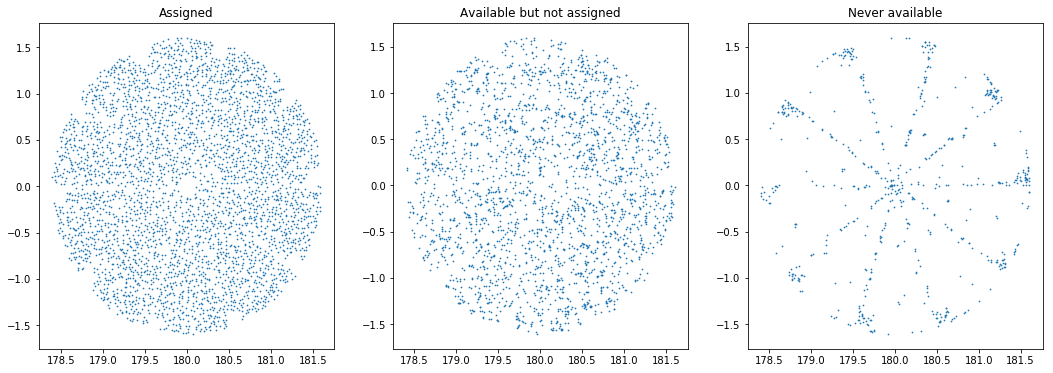

In [23]:
plt.figure(figsize=(18,6))

plt.subplot(131)
plt.title('Assigned')
ii = np.in1d(targets['TARGETID'], obstargets['TARGETID'])
ii = targets['TARGETID'][ii]
plt.scatter(targets['RA'][ii], targets['DEC'][ii], s=0.5)

n_assigned = len(ii)

plt.subplot(132)
#create a list of unique potential targets excluding the assigned ones.
potunique = np.unique(pottargets['TARGETID'])
jj = np.in1d(potunique, obstargets['TARGETID'], invert=True)
potunique = potunique[jj]

jj = np.in1d(targets['TARGETID'], potunique)
jj = targets['TARGETID'][jj]
plt.scatter(targets['RA'][jj], targets['DEC'][jj], s =0.5)
plt.title('Available but not assigned')
n_available_not_assigned = len(jj)

plt.subplot(133)
kk = np.in1d(targets['TARGETID'], np.concatenate([ii,jj]), invert=True)
kk = targets['TARGETID'][kk]
plt.scatter(targets['RA'][kk], targets['DEC'][kk], s=0.5)
plt.title('Never available')
n_unavailable = len(kk)

print(n_assigned, n_available_not_assigned, n_unavailable, len(targets['TARGETID']))

assert (n_assigned + n_available_not_assigned + n_unavailable)==len(targets['TARGETID'])

# Unreachable targets

We want to test whether there are unreachable targets, i.e., 
targets that are never assigned regardles of how the subpriorities are set.


In [38]:
n_runs = 5

all_not_assigned = {}

write_targets()
write_tile()
write_survey()
write_config()


for i in range(n_runs):
    #reset priorities and run fiberassign
    reset_subpriorities()
    run_fiberassign()
    
    #read back the data
    targets = Table.read('mtl.fits')
    obstargets = Table.read('tile_00000.fits', hdu=1)
    pottargets = Table.read('tile_00000.fits', hdu=2)
    
    # Find all the TARGETID that were available but not assigned
    potunique = np.unique(pottargets['POTENTIALTARGETID'])
    jj = np.in1d(potunique, obstargets['TARGETID'], invert=True)
    potunique = potunique[jj]
    jj = np.in1d(targets['TARGETID'], potunique)
    not_assigned = targets['TARGETID'][jj]

    #compile the results in a dictionary
    all_not_assigned[i] = not_assigned

Now we loop over the results and to find the TARGETID that 
are in common between all the runs

In [39]:
common_not_assigned = all_not_assigned[0]
print('Not assigned in run 0', len(not_assigned))
for i in range(1,n_runs):
    not_assigned = all_not_assigned[i]
    ii = np.in1d(common_not_assigned, all_not_assigned[i])
    common_not_assigned = common_not_assigned[ii]
    print(len(common_not_assigned))

Not assigned in run 0 2398
2398
2398
2398
2398


The number of unassigned targets is always the same. 
The fiberassign is completely deterministic regardless of SUBPRIORITY

# Targetting efficiency as a function of number density

We define the efficiency as the ratio between the number of assigned targets to the total number 
of available targets. We want to find how this efficiency changes with the average target number density.

In [100]:
n_dens = 10
n_runs = 5

efficiency = {}
write_tile()
write_survey()
write_config()

number_density = np.linspace(1,3000,n_dens)

for j in range(n_dens):
    eff = np.zeros(n_runs)
    for i in range(n_runs):
        #reset priorities and run fiberassign
        write_targets(n_target_dens=number_density[j])
        run_fiberassign()
    
        #read back the data
        targets = Table.read('mtl.fits')
        obstargets = Table.read('tile_00000.fits', hdu=1)
        pottargets = Table.read('tile_00000.fits', hdu=2)
    
        # Find all the TARGETID that were available but not assigned
        potunique = np.unique(pottargets['POTENTIALTARGETID'])
        jj = np.in1d(potunique, obstargets['TARGETID'], invert=True)
        potunique = potunique[jj]
        jj = np.in1d(targets['TARGETID'], potunique)
        not_assigned = targets['TARGETID'][jj]
        
        # Find all the TARGETID that were assigned
        ii = np.in1d(targets['TARGETID'], obstargets['TARGETID'])
        assigned = targets['TARGETID'][ii]
        
        eff[i] = len(assigned)/(len(not_assigned) + len(assigned))
    #compile the results in a dictionary
    efficiency[j] = eff.copy()

In [101]:
mean_eff = []
sigma_eff = []
for j in range(n_dens):
    mean_eff.append(np.mean(efficiency[j]))
    sigma_eff.append(np.std(efficiency[j]))

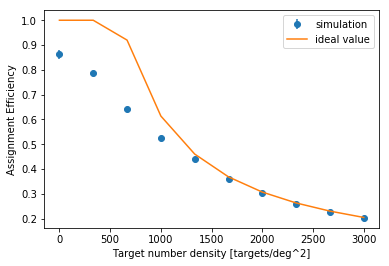

In [102]:
plt.errorbar(number_density, mean_eff, yerr=sigma_eff, fmt='o', label='simulation')
area = np.pi*1.61 **2 
ideal = 5000.0/(number_density * area)
ideal[number_density * area < 5000 ] = 1.0
plt.errorbar(number_density, ideal , label='ideal value')
plt.ylabel('Assignment Efficiency')
plt.xlabel('Target number density [targets/deg^2]')
plt.legend()

In [1]:
!pwd

/global/cscratch1/sd/forero
